In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

from tqdm import tqdm
from pathlib import PurePath

import vxs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Durations of samples in autoencoder training data

In [13]:
vocal_sketch_dataset = vxs.SampleSet(glob.glob(
    '../data/vocal-sketch/interactiveaudiolab-VocalSketchDataSet-6c9f381/vocal_imitations/included/*.wav'), wave_only=True)
drum_machines_dataset = vxs.SampleSet(glob.glob('../data/200-drum-machines/drums/*/*.wav'), wave_only=True)
print(f'vocal sketch: {len(vocal_sketch_dataset)} samples')
print(f'200 drum machines: {len(drum_machines_dataset)} samples')

vocal sketch: 4429 samples
200 drum machines: 6749 samples


In [7]:
def fetch_durations(dataset):
    durations = []
    for i in tqdm(range(len(dataset))):
        track = dataset[i]
        durations.append(track.duration*1000)
    return np.array(durations)

In [8]:
vocal_durations = fetch_durations(vocal_sketch_dataset)

100%|██████████| 4429/4429 [00:01<00:00, 2306.67it/s]


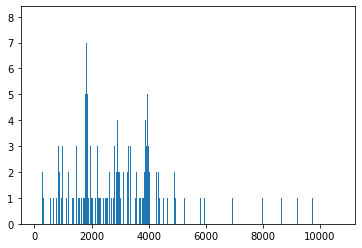

In [9]:
plt.hist(vocal_durations, bins=int(vocal_durations.max() - vocal_durations.min()))
plt.show()

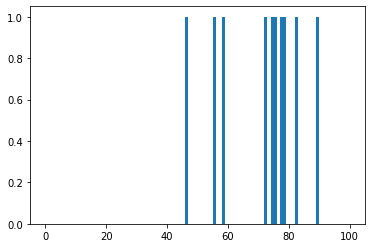

In [10]:
plt.hist(vocal_durations, bins=100, range=(0, 100))
plt.show()

In [14]:
drum_durations = fetch_durations(drum_machines_dataset)

100%|██████████| 6749/6749 [00:18<00:00, 373.21it/s] 


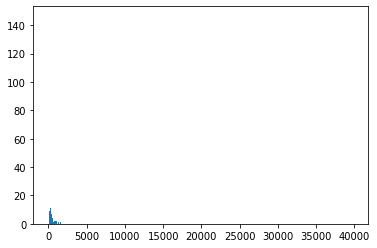

In [15]:
plt.hist(drum_durations, bins=int(drum_durations.max() - drum_durations.min()))
plt.show()

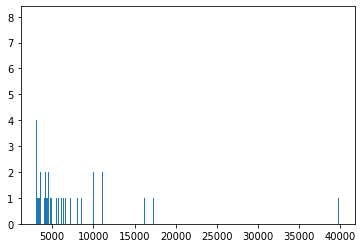

In [16]:
plt.hist(drum_durations, range=(3000, 40000), bins=1000)
plt.show()

## AVP Dataset segments durations stats

The following code has been used for determining inaccurate ground truth onsets in AVP Dataset

In [17]:
avp_set_fixed = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed')
avp_set_personal = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Personal')
fixed_segments = vxs.SegmentSet(avp_set_fixed, frame_window=None)
personal_segments = vxs.SegmentSet(avp_set_personal, frame_window=None)

In [18]:
def min_max_segm_lens(segments):
    min_segm_lens = dict((cl, 100000) for cl in ['kd', 'sd', 'hhc', 'hho'])
    for segm, cl in segments:
        min_segm_lens[cl] = min(min_segm_lens[cl], segm.n_samples)
    
    max_segm_lens = dict((cl, 0) for cl in ['kd', 'sd', 'hhc', 'hho'])
    for segm, cl in fixed_segments:
        max_segm_lens[cl] = max(max_segm_lens[cl], segm.n_samples)
        
    return min_segm_lens, max_segm_lens

def diff_table(ds):
    df = pd.DataFrame(columns=['track', 'min_diff', 'max_diff', 'duration'])
    for track, anno in ds.annotated_tracks():
        times = np.concatenate((anno['time'].values, [track.duration]))
        diffs = times[1:] - times[:-1]
        t_name = PurePath(track.filepath).stem 
        df.loc[len(df)] = [t_name, diffs.min(), diffs.max(), track.duration]
    return df

In [19]:
min_max_segm_lens(fixed_segments)

({'kd': 3839, 'sd': 4287, 'hhc': 1400, 'hho': 2169},
 {'kd': 579120, 'sd': 581744, 'hhc': 628327, 'hho': 580672})

In [20]:
min_max_segm_lens(personal_segments)

({'kd': 3695, 'sd': 3823, 'hhc': 3615, 'hho': 3071},
 {'kd': 579120, 'sd': 581744, 'hhc': 628327, 'hho': 580672})

In [23]:
diff_table(avp_set_fixed)

,track,min_diff,max_diff,duration
0,P27_Improvisation_Fixed,0.120816,0.775692,20.494512
1,P27_HHopened_Fixed,0.159365,0.691429,9.896780
2,P27_Kick_Fixed,0.132789,0.675918,9.943220
3,P27_Snare_Fixed,0.160000,0.657778,9.687800
4,P27_HHclosed_Fixed,0.156372,0.667211,9.827120
...,...,...,...,...
135,P3_HHopened_Fixed,0.140771,0.672653,9.975828
136,P3_Kick_Fixed,0.119546,0.682630,10.036825
137,P3_HHclosed_Fixed,0.157823,0.693878,10.518639
138,P3_Snare_Fixed,0.148753,0.686803,10.460590


In [24]:
diff_table(avp_set_personal)

,track,min_diff,max_diff,duration
0,P27_Improvisation_Personal,0.125533,0.682812,21.251451
1,P27_Snare_Personal,0.141678,0.699864,10.123900
2,P27_HHopened_Personal,0.125170,0.714195,9.884082
3,P27_HHclosed_Personal,0.151474,0.685714,10.987392
4,P27_Kick_Personal,0.140771,0.694785,11.122358
...,...,...,...,...
120,P3_HHopened_Personal,0.145669,0.697415,9.797370
121,P3_Improvisation_Personal,0.203356,0.691338,19.747120
122,P3_Snare_Personal,0.165986,0.704762,12.450249
123,P3_Kick_Personal,0.140771,0.676281,11.045442
